# SPML HW3 - Defensive Distillation (30)

### Deadline: 1402/2/30

#### Name: Javad Hezareh
#### Student No.: 9810174

In this notebook, you are going to attack a defensively distilled model

Please write your code in specified sections and do not change anything else. If you have a question regarding this homework, please ask it on the course page.

Also, it is recommended to use google colab to do this homework. You can connect to your drive using the code below:

## Initializations

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

## Defining Teacher and Student Classes

In [ ]:
class Teacher(nn.Module):
  def __init__(self, num_cls, T=1):
    super().__init__()
    self.conv = nn.Sequential(
        *list(resnet18(pretrained=False).children())[:-2])
    
    self.fc = nn.Linear(512, num_cls)
    self.temp = T
  
  def forward(self, x, T=None):
    if T is None:
      T = self.temp
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    output = torch.softmax(logits / T, dim=1)

    return logits, output

class Student(nn.Module):
  def __init__(self, num_cls, T=1):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_cls)
    self.temp = T

  def forward(self, x, T=None):
    if T is None:
      T = self.temp
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    logits = self.fc3(x)

    output = torch.softmax(logits / T, dim=1)
    return logits, output

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

###################### Problem 1 (3 points) ####################################
# todo: Define your data loaders for training, testing, and validation         #
################################################################################
trainset, valset = random_split(trainset, [0.8, 0.2])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
################################ End ###########################################

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

100%|██████████| 170498071/170498071 [00:13<00:00, 12408801.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Training

### Teacher Network Training

In [ ]:
def standard_train(model, loader, num_epoch, optimizer, criterion, T=None, 
                   device=device):
    ###################### Problem 2 (4 points) ##################################
    # todo: Iterate over loader in each epoch                                    #
    # todo: Compute the model's output for each batch at the given temperature T #
    # todo: Compute the loss function and take a step by the optimizer           #
    # todo: Monitor the training procedure                                       #
    ##############################################################################
    losses = []
    # your code goes here
    for e in range(num_epoch):
        total_loss = 0
        N = 0
        with tqdm(enumerate(loader), total=len(loader)) as pbar:
            for i, (imgs, labels) in pbar:
                imgs = imgs.to(device)
                labels = labels.to(device)
                b_size = len(labels)

                optimizer.zero_grad()
                logits, output = model(imgs, T)

                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                total_loss += loss.item() * b_size
                N += b_size

                pbar.set_description(f"Epoch{e}: total_loss={total_loss/N:.3f}")
        
        print(f"------------- [Epoch{e} Finished!] -------------")

    plt.plot(losses);
    ##############################################################################

In [ ]:
T = 100
teacher = Teacher(len(classes), T=T).to(device)
teacher_optim = optim.Adam(teacher.parameters())
teacher_criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch0: total_loss=2.155: 100%|██████████| 313/313 [00:27<00:00, 11.20it/s]


------------- [Epoch0 Finished!] -------------


Epoch1: total_loss=1.963: 100%|██████████| 313/313 [00:20<00:00, 14.94it/s]


------------- [Epoch1 Finished!] -------------


Epoch2: total_loss=1.888: 100%|██████████| 313/313 [00:20<00:00, 14.95it/s]


------------- [Epoch2 Finished!] -------------


Epoch3: total_loss=1.835: 100%|██████████| 313/313 [00:21<00:00, 14.49it/s]


------------- [Epoch3 Finished!] -------------


Epoch4: total_loss=1.802: 100%|██████████| 313/313 [00:20<00:00, 15.36it/s]


------------- [Epoch4 Finished!] -------------


Epoch5: total_loss=1.779: 100%|██████████| 313/313 [00:20<00:00, 14.95it/s]


------------- [Epoch5 Finished!] -------------


Epoch6: total_loss=1.761: 100%|██████████| 313/313 [00:20<00:00, 15.39it/s]


------------- [Epoch6 Finished!] -------------


Epoch7: total_loss=1.743: 100%|██████████| 313/313 [00:26<00:00, 11.87it/s]


------------- [Epoch7 Finished!] -------------


Epoch8: total_loss=1.730: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s]


------------- [Epoch8 Finished!] -------------


Epoch9: total_loss=1.718: 100%|██████████| 313/313 [00:21<00:00, 14.41it/s]


------------- [Epoch9 Finished!] -------------


Epoch10: total_loss=1.704: 100%|██████████| 313/313 [00:21<00:00, 14.28it/s]


------------- [Epoch10 Finished!] -------------


Epoch11: total_loss=1.694: 100%|██████████| 313/313 [00:20<00:00, 15.07it/s]


------------- [Epoch11 Finished!] -------------


Epoch12: total_loss=1.686: 100%|██████████| 313/313 [00:20<00:00, 15.37it/s]


------------- [Epoch12 Finished!] -------------


Epoch13: total_loss=1.681: 100%|██████████| 313/313 [00:20<00:00, 15.05it/s]


------------- [Epoch13 Finished!] -------------


Epoch14: total_loss=1.670: 100%|██████████| 313/313 [00:21<00:00, 14.90it/s]


------------- [Epoch14 Finished!] -------------


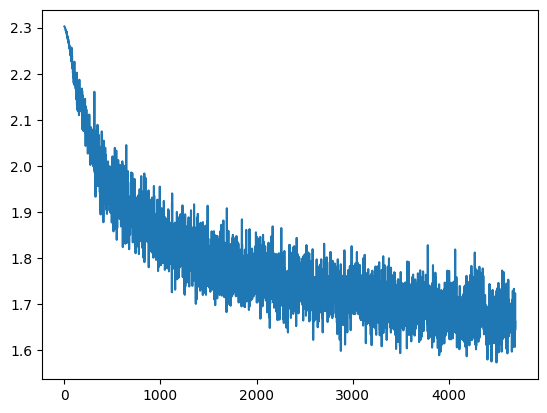

In [ ]:
standard_train(model=teacher, 
            loader=trainloader, 
            num_epoch=15, 
            optimizer=teacher_optim, 
            criterion=teacher_criterion, 
            T=T, 
            device=device)

### Student Network Training

In [ ]:
def distillation(teacher, student, loader, num_epoch, optimizer, criterion, 
                 T=None, device=device):
    ###################### Problem 3 (6 points) ##################################
    # todo: Iterate over loader in each epoch                                    #
    # todo: Compute MSE loss between student's logit and teacher's logit         #
    # todo: Take a step by the optimizer                                         #
    # todo: Monitor the training procedure                                       #
    ##############################################################################
    losses = []
    # your code goes here
    for e in range(num_epoch):
        total_loss = 0
        N = 0
        with tqdm(enumerate(loader), total=len(loader)) as pbar:
            for i, (imgs, labels) in pbar:
                imgs = imgs.to(device)
                labels = labels.to(device)
                b_size = len(labels)

                optimizer.zero_grad()
                teacher_logits, _ = teacher(imgs, T)
                student_logits, _ = student(imgs, T)

                loss = criterion(student_logits, teacher_logits)
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                total_loss += loss.item() * b_size
                N += b_size

                pbar.set_description(f"Epoch{e}: total_loss={total_loss/N:.3f}")
        
        print(f"------------- [Epoch{e} Finished!] -------------")

    plt.plot(losses);
  ################################ End #########################################

In [ ]:
T = 100
student = Student(len(classes), T=T).to(device)
student_optim = optim.Adam(student.parameters())
std_criterion = nn.MSELoss()

Epoch0: total_loss=198100.092: 100%|██████████| 313/313 [00:21<00:00, 14.84it/s]


------------- [Epoch0 Finished!] -------------


Epoch1: total_loss=170915.638: 100%|██████████| 313/313 [00:20<00:00, 15.23it/s]


------------- [Epoch1 Finished!] -------------


Epoch2: total_loss=169812.485: 100%|██████████| 313/313 [00:20<00:00, 15.42it/s]


------------- [Epoch2 Finished!] -------------


Epoch3: total_loss=165496.248: 100%|██████████| 313/313 [00:20<00:00, 15.30it/s]


------------- [Epoch3 Finished!] -------------


Epoch4: total_loss=140066.198: 100%|██████████| 313/313 [00:20<00:00, 14.98it/s]


------------- [Epoch4 Finished!] -------------


Epoch5: total_loss=132991.892: 100%|██████████| 313/313 [00:20<00:00, 15.34it/s]


------------- [Epoch5 Finished!] -------------


Epoch6: total_loss=129602.584: 100%|██████████| 313/313 [00:22<00:00, 14.04it/s]


------------- [Epoch6 Finished!] -------------


Epoch7: total_loss=122929.354: 100%|██████████| 313/313 [00:21<00:00, 14.37it/s]


------------- [Epoch7 Finished!] -------------


Epoch8: total_loss=113515.059: 100%|██████████| 313/313 [00:20<00:00, 15.53it/s]


------------- [Epoch8 Finished!] -------------


Epoch9: total_loss=108526.398: 100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


------------- [Epoch9 Finished!] -------------


Epoch10: total_loss=104722.767: 100%|██████████| 313/313 [00:21<00:00, 14.89it/s]


------------- [Epoch10 Finished!] -------------


Epoch11: total_loss=100935.481: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


------------- [Epoch11 Finished!] -------------


Epoch12: total_loss=97910.470: 100%|██████████| 313/313 [00:20<00:00, 15.24it/s]


------------- [Epoch12 Finished!] -------------


Epoch13: total_loss=95126.368: 100%|██████████| 313/313 [00:21<00:00, 14.90it/s]


------------- [Epoch13 Finished!] -------------


Epoch14: total_loss=92803.912: 100%|██████████| 313/313 [00:20<00:00, 15.14it/s]


------------- [Epoch14 Finished!] -------------


Epoch15: total_loss=90244.150: 100%|██████████| 313/313 [00:20<00:00, 15.54it/s]


------------- [Epoch15 Finished!] -------------


Epoch16: total_loss=88330.414: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


------------- [Epoch16 Finished!] -------------


Epoch17: total_loss=86614.217: 100%|██████████| 313/313 [00:20<00:00, 15.18it/s]


------------- [Epoch17 Finished!] -------------


Epoch18: total_loss=84719.350: 100%|██████████| 313/313 [00:20<00:00, 15.07it/s]


------------- [Epoch18 Finished!] -------------


Epoch19: total_loss=83203.567: 100%|██████████| 313/313 [00:20<00:00, 15.26it/s]


------------- [Epoch19 Finished!] -------------


Epoch20: total_loss=81819.557: 100%|██████████| 313/313 [00:21<00:00, 14.50it/s]


------------- [Epoch20 Finished!] -------------


Epoch21: total_loss=80521.951: 100%|██████████| 313/313 [00:20<00:00, 15.00it/s]


------------- [Epoch21 Finished!] -------------


Epoch22: total_loss=79268.638: 100%|██████████| 313/313 [00:21<00:00, 14.87it/s]


------------- [Epoch22 Finished!] -------------


Epoch23: total_loss=77938.511: 100%|██████████| 313/313 [00:21<00:00, 14.82it/s]


------------- [Epoch23 Finished!] -------------


Epoch24: total_loss=77034.491: 100%|██████████| 313/313 [00:20<00:00, 14.94it/s]


------------- [Epoch24 Finished!] -------------


Epoch25: total_loss=75634.776: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


------------- [Epoch25 Finished!] -------------


Epoch26: total_loss=74708.056: 100%|██████████| 313/313 [00:21<00:00, 14.87it/s]


------------- [Epoch26 Finished!] -------------


Epoch27: total_loss=73423.731: 100%|██████████| 313/313 [00:21<00:00, 14.86it/s]


------------- [Epoch27 Finished!] -------------


Epoch28: total_loss=72432.183: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


------------- [Epoch28 Finished!] -------------


Epoch29: total_loss=71749.538: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


------------- [Epoch29 Finished!] -------------


Epoch30: total_loss=70499.423: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


------------- [Epoch30 Finished!] -------------


Epoch31: total_loss=69335.200: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


------------- [Epoch31 Finished!] -------------


Epoch32: total_loss=68471.961: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


------------- [Epoch32 Finished!] -------------


Epoch33: total_loss=67623.212: 100%|██████████| 313/313 [00:20<00:00, 15.60it/s]


------------- [Epoch33 Finished!] -------------


Epoch34: total_loss=66825.572: 100%|██████████| 313/313 [00:21<00:00, 14.65it/s]


------------- [Epoch34 Finished!] -------------


Epoch35: total_loss=66299.740: 100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


------------- [Epoch35 Finished!] -------------


Epoch36: total_loss=65673.252: 100%|██████████| 313/313 [00:21<00:00, 14.44it/s]


------------- [Epoch36 Finished!] -------------


Epoch37: total_loss=64912.613: 100%|██████████| 313/313 [00:22<00:00, 14.05it/s]


------------- [Epoch37 Finished!] -------------


Epoch38: total_loss=64357.267: 100%|██████████| 313/313 [00:22<00:00, 14.08it/s]


------------- [Epoch38 Finished!] -------------


Epoch39: total_loss=63272.427: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


------------- [Epoch39 Finished!] -------------


Epoch40: total_loss=63028.407: 100%|██████████| 313/313 [00:21<00:00, 14.64it/s]


------------- [Epoch40 Finished!] -------------


Epoch41: total_loss=62422.708: 100%|██████████| 313/313 [00:21<00:00, 14.52it/s]


------------- [Epoch41 Finished!] -------------


Epoch42: total_loss=61733.066: 100%|██████████| 313/313 [00:21<00:00, 14.51it/s]


------------- [Epoch42 Finished!] -------------


Epoch43: total_loss=61198.237: 100%|██████████| 313/313 [00:21<00:00, 14.30it/s]


------------- [Epoch43 Finished!] -------------


Epoch44: total_loss=60466.754: 100%|██████████| 313/313 [00:20<00:00, 14.99it/s]


------------- [Epoch44 Finished!] -------------


Epoch45: total_loss=59984.676: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s]


------------- [Epoch45 Finished!] -------------


Epoch46: total_loss=59722.211: 100%|██████████| 313/313 [00:20<00:00, 15.07it/s]


------------- [Epoch46 Finished!] -------------


Epoch47: total_loss=58909.287: 100%|██████████| 313/313 [00:22<00:00, 13.83it/s]


------------- [Epoch47 Finished!] -------------


Epoch48: total_loss=58415.999: 100%|██████████| 313/313 [00:22<00:00, 14.09it/s]


------------- [Epoch48 Finished!] -------------


Epoch49: total_loss=58248.514: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


------------- [Epoch49 Finished!] -------------


Epoch50: total_loss=57781.082: 100%|██████████| 313/313 [00:20<00:00, 15.40it/s]


------------- [Epoch50 Finished!] -------------


Epoch51: total_loss=57098.488: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


------------- [Epoch51 Finished!] -------------


Epoch52: total_loss=57036.331: 100%|██████████| 313/313 [00:21<00:00, 14.75it/s]


------------- [Epoch52 Finished!] -------------


Epoch53: total_loss=56686.969: 100%|██████████| 313/313 [00:21<00:00, 14.80it/s]


------------- [Epoch53 Finished!] -------------


Epoch54: total_loss=56351.939: 100%|██████████| 313/313 [00:20<00:00, 15.07it/s]


------------- [Epoch54 Finished!] -------------


Epoch55: total_loss=55808.209: 100%|██████████| 313/313 [00:20<00:00, 15.23it/s]


------------- [Epoch55 Finished!] -------------


Epoch56: total_loss=55409.048: 100%|██████████| 313/313 [00:20<00:00, 14.91it/s]


------------- [Epoch56 Finished!] -------------


Epoch57: total_loss=54966.663: 100%|██████████| 313/313 [00:20<00:00, 14.92it/s]


------------- [Epoch57 Finished!] -------------


Epoch58: total_loss=54513.756: 100%|██████████| 313/313 [00:20<00:00, 15.60it/s]


------------- [Epoch58 Finished!] -------------


Epoch59: total_loss=54191.815: 100%|██████████| 313/313 [00:21<00:00, 14.48it/s]


------------- [Epoch59 Finished!] -------------


Epoch60: total_loss=53930.042: 100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


------------- [Epoch60 Finished!] -------------


Epoch61: total_loss=53606.202: 100%|██████████| 313/313 [00:20<00:00, 15.61it/s]


------------- [Epoch61 Finished!] -------------


Epoch62: total_loss=53321.808: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


------------- [Epoch62 Finished!] -------------


Epoch63: total_loss=53026.332: 100%|██████████| 313/313 [00:20<00:00, 15.65it/s]


------------- [Epoch63 Finished!] -------------


Epoch64: total_loss=52673.840: 100%|██████████| 313/313 [00:20<00:00, 15.18it/s]


------------- [Epoch64 Finished!] -------------


Epoch65: total_loss=52512.691: 100%|██████████| 313/313 [00:21<00:00, 14.56it/s]


------------- [Epoch65 Finished!] -------------


Epoch66: total_loss=52116.929: 100%|██████████| 313/313 [00:20<00:00, 15.16it/s]


------------- [Epoch66 Finished!] -------------


Epoch67: total_loss=52038.958: 100%|██████████| 313/313 [00:21<00:00, 14.81it/s]


------------- [Epoch67 Finished!] -------------


Epoch68: total_loss=51543.041: 100%|██████████| 313/313 [00:21<00:00, 14.41it/s]


------------- [Epoch68 Finished!] -------------


Epoch69: total_loss=51728.573: 100%|██████████| 313/313 [00:21<00:00, 14.46it/s]


------------- [Epoch69 Finished!] -------------


Epoch70: total_loss=51156.484: 100%|██████████| 313/313 [00:21<00:00, 14.32it/s]


------------- [Epoch70 Finished!] -------------


Epoch71: total_loss=50972.507: 100%|██████████| 313/313 [00:21<00:00, 14.44it/s]


------------- [Epoch71 Finished!] -------------


Epoch72: total_loss=50533.553: 100%|██████████| 313/313 [00:21<00:00, 14.51it/s]


------------- [Epoch72 Finished!] -------------


Epoch73: total_loss=50453.473: 100%|██████████| 313/313 [00:21<00:00, 14.42it/s]


------------- [Epoch73 Finished!] -------------


Epoch74: total_loss=50280.790: 100%|██████████| 313/313 [00:21<00:00, 14.41it/s]


------------- [Epoch74 Finished!] -------------


Epoch75: total_loss=50109.316: 100%|██████████| 313/313 [00:21<00:00, 14.54it/s]


------------- [Epoch75 Finished!] -------------


Epoch76: total_loss=49539.389: 100%|██████████| 313/313 [00:21<00:00, 14.47it/s]


------------- [Epoch76 Finished!] -------------


Epoch77: total_loss=49702.668: 100%|██████████| 313/313 [00:21<00:00, 14.29it/s]


------------- [Epoch77 Finished!] -------------


Epoch78: total_loss=49463.906: 100%|██████████| 313/313 [00:21<00:00, 14.49it/s]


------------- [Epoch78 Finished!] -------------


Epoch79: total_loss=49162.915: 100%|██████████| 313/313 [00:22<00:00, 14.16it/s]


------------- [Epoch79 Finished!] -------------


Epoch80: total_loss=48968.265: 100%|██████████| 313/313 [00:21<00:00, 14.47it/s]


------------- [Epoch80 Finished!] -------------


Epoch81: total_loss=48795.146: 100%|██████████| 313/313 [00:20<00:00, 14.99it/s]


------------- [Epoch81 Finished!] -------------


Epoch82: total_loss=48561.102: 100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


------------- [Epoch82 Finished!] -------------


Epoch83: total_loss=48752.784: 100%|██████████| 313/313 [00:21<00:00, 14.72it/s]


------------- [Epoch83 Finished!] -------------


Epoch84: total_loss=48227.998: 100%|██████████| 313/313 [00:21<00:00, 14.64it/s]


------------- [Epoch84 Finished!] -------------


Epoch85: total_loss=47984.400: 100%|██████████| 313/313 [00:21<00:00, 14.69it/s]


------------- [Epoch85 Finished!] -------------


Epoch86: total_loss=48260.232: 100%|██████████| 313/313 [00:21<00:00, 14.53it/s]


------------- [Epoch86 Finished!] -------------


Epoch87: total_loss=47997.011: 100%|██████████| 313/313 [00:21<00:00, 14.56it/s]


------------- [Epoch87 Finished!] -------------


Epoch88: total_loss=47732.062: 100%|██████████| 313/313 [00:21<00:00, 14.63it/s]


------------- [Epoch88 Finished!] -------------


Epoch89: total_loss=47484.235: 100%|██████████| 313/313 [00:21<00:00, 14.80it/s]


------------- [Epoch89 Finished!] -------------


Epoch90: total_loss=47489.262: 100%|██████████| 313/313 [00:21<00:00, 14.56it/s]


------------- [Epoch90 Finished!] -------------


Epoch91: total_loss=47227.638: 100%|██████████| 313/313 [00:20<00:00, 15.38it/s]


------------- [Epoch91 Finished!] -------------


Epoch92: total_loss=46985.349: 100%|██████████| 313/313 [00:20<00:00, 15.11it/s]


------------- [Epoch92 Finished!] -------------


Epoch93: total_loss=47015.703: 100%|██████████| 313/313 [00:20<00:00, 15.14it/s]


------------- [Epoch93 Finished!] -------------


Epoch94: total_loss=46741.142: 100%|██████████| 313/313 [00:20<00:00, 15.54it/s]


------------- [Epoch94 Finished!] -------------


Epoch95: total_loss=46703.339: 100%|██████████| 313/313 [00:20<00:00, 15.23it/s]


------------- [Epoch95 Finished!] -------------


Epoch96: total_loss=46264.129: 100%|██████████| 313/313 [00:20<00:00, 15.02it/s]


------------- [Epoch96 Finished!] -------------


Epoch97: total_loss=46312.716: 100%|██████████| 313/313 [00:20<00:00, 15.25it/s]


------------- [Epoch97 Finished!] -------------


Epoch98: total_loss=46410.511: 100%|██████████| 313/313 [00:21<00:00, 14.88it/s]


------------- [Epoch98 Finished!] -------------


Epoch99: total_loss=46081.029: 100%|██████████| 313/313 [00:21<00:00, 14.87it/s]


------------- [Epoch99 Finished!] -------------


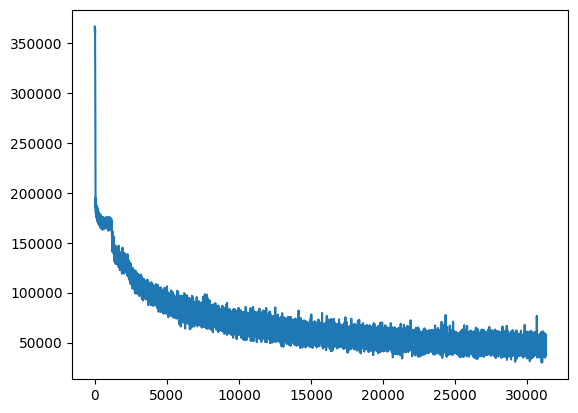

In [ ]:
distillation(teacher=teacher, 
             student=student, 
             loader=trainloader, 
             num_epoch=100, 
             optimizer=student_optim, 
             criterion=std_criterion, 
             T=T, 
             device=device)

### Computing Clean Accuracy

In [ ]:
def standard_test(model, loader, T=1, device=device):
    correct = 0
    total = 0
    ###################### Problem 4 (3 points) ##################################
    # todo: Iterate over loader, compute the output and predicted                #
    # label, and update "correct" and "total" counters accordingly.              # 
    ##############################################################################
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            _, probs = model(imgs, T)
            preds = torch.argmax(probs, dim=1)

            total += len(imgs)
            correct += (preds == labels).sum().item()
    ################################ End #########################################
    print(f'Clean accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
standard_test(teacher, testloader)

Clean accuracy of the network on the 10000 test images: 71 %


In [ ]:
standard_test(student, testloader)

Clean accuracy of the network on the 10000 test images: 62 %


## Attacks

In [ ]:
def fgsm_attack (model, X, y, epsilon, T=1, mode="output"):
    delta = torch.zeros_like(X, requires_grad=True).to(device)
    ###################### Problem 5 (9 points) ######################
    # todo: Perform forward path on model with the image             #
    # todo: Compute loss:                                            #
    #       - In output mode, set cross entropy as the loss function #
    #       - In logit mode, set the logit value of the target label #
    #         as the loss function                                   #
    # todo: Perform backward path on loss function                   #
    # todo: Calculate the gradient w.r.t. the data                   #
    # todo: Determine delta based on the gradient and epsilon        #
    # Also, if the perturbed image exceeds the valid range, clamp    #
    # the delta in order to obtain an image in the valid range       #  
    ##################################################################
    X = X.detach().clone().to(device)
    X.requires_grad_()
    y = y.to(device)

    logits, probs = model(X, T)
    loss = None
    if mode == 'output':
        loss = F.cross_entropy(probs, y)
    else:
        # performing untargeted attack
        loss = - logits[range(len(y)), y].sum()
    loss.backward()

    delta = torch.clamp(X.grad, min=-epsilon, max=epsilon)
    new_X = torch.clamp(X + delta, min=0, max=1)
    ########################### End ##################################
    # return delta + X
    return new_X

In [ ]:
def attack_test(model, attack_model, loader, mode="output", epsilon=4/255, T=1, 
                device=device):
    correct = 0
    total = 0
    ###################### Problem 6 (4.5 points) ################################
    # todo: Iterate over loader                                                  #
    # todo: Find an adversarial example by FGSM attack on attack_model           #
    # todo: Compute the output and predicted label, and updated "correct" and    #
    # "total" counters accordingly.                                              # 
    ##############################################################################
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        attack_imgs = fgsm_attack(attack_model, imgs, labels, epsilon, T, mode)
        
        _, probs = model(attack_imgs, T)
        preds = torch.argmax(probs, dim=1)

        total += len(imgs)
        correct += (preds == labels).sum().item()
    ################################ End #########################################
    print(f'Accuracy of the network on the 10000 test images after attacking {mode} layer: {100 * correct // total} %')

In [ ]:
###################### Problem 7 (1.5 points) ##################################
# todo: Report the accuracy of the student model under attack output and logit #
#       layers                                                                 #
# todo: Do not forget to set the temperature of the student model to 1         #
################################################################################
attack_test(student, student, testloader, mode="output")
attack_test(student, student, testloader, mode="logit")
################################ End ###########################################

Accuracy of the network on the 10000 test images after attacking output layer: 32 %
Accuracy of the network on the 10000 test images after attacking logit layer: 22 %
